In [1]:
import numpy as np
import pandas as pd

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

def getData(grid):
    x1 = np.linspace(0, 1, grid)
    x2 = np.linspace(0, 1, grid)
    x1, x2 = np.meshgrid(x1, x2)
    f_x1_x2 = benchmark(x1, x2)
    data = {'x1': x1.flatten(), 'x2': x2.flatten(), 'f(x1,x2)': f_x1_x2.flatten()}
    df = pd.DataFrame(data)
    return df


df_1000 = getData(32)
df_test = pd.read_excel("../Kriging-data.xlsx", sheet_name="Test")
df_training = pd.read_excel("../Kriging-data.xlsx", sheet_name="Training")

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Spherical")

/tmp/ipykernel_2111330/3524821835.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


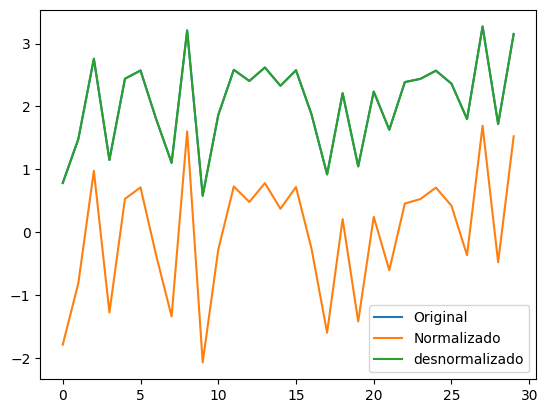

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-07-31 03:56:40.403125: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 03:56:40.437102: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 03:56:40.437147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 03:56:40.438375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 03:56:40.444414: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-31 03:56:40.445082: I tensorflow/core/platform/cpu_feature_guard.cc:1

2024-07-31 03:56:41.305829: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, input, output, sup_input, sup_output):
      input_train, input_vt, output_train, output_vt = train_test_split(input, output, test_size=0.3, shuffle = True)
      input_val, input_test, output_val, output_test = train_test_split(input_vt, output_vt, test_size=0.5, shuffle = True)

      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(input_test, output_test)
      self.vt_dataset, self.vt_input, self.vt_output = self.create_dataset(input_vt, output_vt)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(sup_input, sup_output)
      self.dataset, self.input, self.output = self.create_dataset(input, output)

      self._data = (input, output)
      self._train = (input_train, output_train)
      self._vt = (input_vt, output_vt)
      self._val = (input_val, output_val)
      self._test = (input_test, output_test)
      self._sup = (sup_input, sup_output)

    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)

      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          vt_pred = self.lm_model.predict(self.vt_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          vt_pred_denorm = out_scaler.inverse_transform(vt_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          vt_denorm = out_scaler.inverse_transform(self._vt[1].reshape(-1, 1))    
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_vt = r2_score(vt_denorm,  vt_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_vt = mean_squared_error(vt_denorm,  vt_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'r2_vt': r2_vt,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mse_vt': mse_vt,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product

class Tester:
  def __init__(self, _df, _df_1000,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._vt, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self.input, self.output, self.input_1000, self.output_1000)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(_df=df_virtual_norm,
                _df_1000=df_1000_norm,
                run_times=50, dataset_run_times=10)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++

Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 12 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 14 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 16 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 17 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 18 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 19 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 20 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 22 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 145ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 23 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 24 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 25 ++++++++++++++++++


Stopped at epoch: 

 6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 27 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 28 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 29 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 31 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 32 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 33 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 34 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 35 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 36 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 37 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 38 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 39 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 40 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 41 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 42 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 43 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 44 ++++++++++++++++++


Stopped at epoch:  7


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 45 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 46 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 47 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 48 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 49 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 50 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_49,0.988234,0.669386,0.973206,0.974380,0.975339,0.004549,0.196267,0.010745,0.004727,0.007736,0.031808,0.067443,0.975487,0.067984,140.785912,325.144236
model_1_0_48,0.987578,0.669268,0.971965,0.972282,0.973928,0.004802,0.196337,0.011243,0.005114,0.008179,0.033302,0.069298,0.974120,0.069854,140.677380,325.035704
model_1_0_47,0.986285,0.667249,0.971001,0.970472,0.972780,0.005302,0.197536,0.011630,0.005448,0.008539,0.035182,0.072814,0.971427,0.073399,140.479398,324.837722
model_1_0_40,0.969998,0.664751,0.963388,0.939193,0.958715,0.011598,0.199018,0.014683,0.011219,0.012951,0.051611,0.107695,0.937495,0.108560,138.913816,323.272140
model_1_0_39,0.969485,0.664513,0.963075,0.938069,0.958184,0.011796,0.199160,0.014808,0.011426,0.013117,0.052060,0.108611,0.936428,0.109483,138.879947,323.238271
model_1_0_38,0.969005,0.664436,0.962772,0.937166,0.957725,0.011982,0.199205,0.014930,0.011593,0.013261,0.052464,0.109461,0.935428,0.110341,138.848737,323.207061
model_1_0_41,0.970287,0.664342,0.963481,0.939341,0.958818,0.011486,0.199261,0.014646,0.011192,0.012919,0.051431,0.107174,0.938098,0.108035,138.933188,323.291512
model_1_0_37,0.967438,0.663559,0.961227,0.935100,0.956130,0.012588,0.199726,0.015549,0.011974,0.013762,0.053926,0.112195,0.932162,0.113096,138.750062,323.108386
model_1_0_46,0.983400,0.663470,0.968347,0.967458,0.970197,0.006417,0.199779,0.012694,0.006004,0.009349,0.039344,0.080108,0.965416,0.080752,140.097515,324.455839
model_1_0_43,0.973593,0.662791,0.964743,0.948581,0.962342,0.010208,0.200182,0.014139,0.009487,0.011813,0.049104,0.101036,0.944985,0.101848,139.169102,323.527426


DataFrame salvo em ../results/metrics_1_0


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  22
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 11 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 12 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 13 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 14 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 15 ++++++++++++++++++


Stopped at epoch:  22
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 16 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 17 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 18 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 19 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 20 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 22 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 23 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 24 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 25 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 26 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 27 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 28 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 29 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 30 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 31 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 33 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 34 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 35 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 36 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 37 ++++++++++++++++++


Stopped at epoch:  63
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 38 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 39 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_1] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 41 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 42 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 43 ++++++++++++++++++


Stopped at epoch:  39
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 44 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 46 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 47 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 48 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 49 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 50 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_41,0.994065,0.692962,0.984810,0.975616,0.981379,0.002294,0.182271,0.005632,0.008355,0.006994,0.013532,0.047900,0.987635,0.048285,142.154570,326.512894
model_1_1_38,0.993978,0.692950,0.984498,0.975411,0.981131,0.002328,0.182278,0.005748,0.008426,0.007087,0.013696,0.048249,0.987454,0.048637,142.125505,326.483829
model_1_1_42,0.994092,0.692946,0.985254,0.975185,0.981401,0.002284,0.182281,0.005467,0.008503,0.006985,0.013293,0.047789,0.987692,0.048173,142.163845,326.522169
model_1_1_39,0.993992,0.692899,0.984536,0.975466,0.981175,0.002323,0.182309,0.005733,0.008407,0.007070,0.013686,0.048194,0.987483,0.048581,142.130122,326.488446
model_1_1_40,0.994019,0.692813,0.984585,0.975617,0.981268,0.002312,0.182359,0.005715,0.008355,0.007035,0.013662,0.048083,0.987540,0.048469,142.139322,326.497646
model_1_1_36,0.993718,0.692761,0.983673,0.974617,0.980362,0.002429,0.182390,0.006053,0.008698,0.007376,0.014174,0.049280,0.986912,0.049676,142.040912,326.399236
model_1_1_37,0.993925,0.692652,0.984207,0.975390,0.980978,0.002348,0.182455,0.005856,0.008433,0.007144,0.013849,0.048461,0.987344,0.048850,142.108008,326.466332
model_1_1_43,0.994139,0.692641,0.985428,0.975324,0.981551,0.002266,0.182462,0.005403,0.008455,0.006929,0.013249,0.047601,0.987789,0.047983,142.179617,326.537941
model_1_1_44,0.994140,0.692638,0.985521,0.975212,0.981545,0.002266,0.182463,0.005368,0.008494,0.006931,0.013289,0.047597,0.987791,0.047980,142.179918,326.538242
model_1_1_46,0.994124,0.692513,0.985722,0.974803,0.981458,0.002272,0.182538,0.005294,0.008634,0.006964,0.013263,0.047661,0.987758,0.048044,142.174540,326.532864


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  22
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 11 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 13 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 14 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 17 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 19 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 22 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 23 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 24 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 25 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 27 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 30 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 31 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 32 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 33 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 37 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 39 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 41 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 42 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 44 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 45 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 48 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_0,0.994233,0.690407,0.993177,0.998521,0.997039,0.002229,0.183788,0.001724,0.000509,0.001116,0.013995,0.047217,0.987985,0.047596,142.212009,326.570333
model_1_2_5,0.995031,0.687569,0.992195,0.993554,0.994445,0.001921,0.185472,0.001972,0.002217,0.002094,0.018503,0.043828,0.989648,0.044180,142.509914,326.868238
model_1_2_4,0.994858,0.687448,0.992418,0.993931,0.994691,0.001988,0.185544,0.001916,0.002087,0.002001,0.018491,0.044583,0.989288,0.044941,142.441594,326.799918
model_1_2_8,0.995671,0.686774,0.992823,0.992800,0.994311,0.001674,0.185944,0.001813,0.002476,0.002145,0.017300,0.040909,0.990981,0.041237,142.785665,327.143989
model_1_2_6,0.995303,0.686547,0.992336,0.993217,0.994338,0.001816,0.186079,0.001936,0.002333,0.002135,0.018142,0.042610,0.990215,0.042952,142.622657,326.980981
model_1_2_1,0.994460,0.685313,0.993652,0.996760,0.996395,0.002142,0.186812,0.001604,0.001114,0.001359,0.016592,0.046279,0.988458,0.046651,142.292244,326.650568
model_1_2_7,0.995559,0.685228,0.992526,0.992784,0.994205,0.001717,0.186862,0.001888,0.002482,0.002185,0.017696,0.041434,0.990748,0.041767,142.734588,327.092911
model_1_2_9,0.995903,0.684696,0.993023,0.992276,0.994139,0.001584,0.187178,0.001763,0.002657,0.002210,0.017210,0.039799,0.991464,0.040119,142.895660,327.253984
model_1_2_3,0.994439,0.684500,0.993283,0.995718,0.995796,0.002150,0.187295,0.001697,0.001473,0.001585,0.017524,0.046366,0.988414,0.046739,142.284714,326.643038
model_1_2_2,0.994402,0.684373,0.993295,0.995822,0.995848,0.002164,0.187370,0.001694,0.001437,0.001566,0.017524,0.046520,0.988337,0.046894,142.271493,326.629817


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 11 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 12 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 13 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 14 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 15 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 16 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 17 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 18 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 19 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 20 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 21 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 22 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 23 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 25 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 27 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 28 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 29 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 32 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 33 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 34 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 35 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 37 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 38 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 40 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 41 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 43 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 44 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 46 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 49 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 50 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_6,0.998214,0.679335,0.998348,0.996129,0.997702,0.000691,0.190361,0.000762,0.000891,0.000827,0.011736,0.026278,0.996279,0.026489,144.556151,328.914475
model_1_3_4,0.998177,0.677589,0.998723,0.996814,0.998161,0.000705,0.191397,0.000589,0.000734,0.000661,0.011756,0.026548,0.996202,0.026761,144.515262,328.873586
model_1_3_5,0.998156,0.677457,0.998482,0.996603,0.997939,0.000713,0.191476,0.000700,0.000782,0.000741,0.012041,0.026700,0.996158,0.026915,144.492356,328.850680
model_1_3_8,0.998179,0.676142,0.997680,0.995238,0.996988,0.000704,0.192256,0.001070,0.001097,0.001084,0.011973,0.026536,0.996205,0.026749,144.517045,328.875369
model_1_3_9,0.998113,0.675617,0.997178,0.995015,0.996595,0.000730,0.192568,0.001302,0.001148,0.001225,0.012292,0.027011,0.996068,0.027228,144.446071,328.804395
model_1_3_7,0.998176,0.675468,0.997803,0.995823,0.997254,0.000705,0.192656,0.001013,0.000962,0.000988,0.012066,0.026554,0.996200,0.026767,144.514300,328.872624
model_1_3_3,0.998149,0.675427,0.999074,0.997354,0.998559,0.000716,0.192681,0.000427,0.000609,0.000518,0.011371,0.026751,0.996144,0.026965,144.484808,328.843132
model_1_3_2,0.998127,0.675141,0.999061,0.997347,0.998549,0.000724,0.192850,0.000433,0.000611,0.000522,0.011471,0.026906,0.996099,0.027122,144.461620,328.819944
model_1_3_11,0.998137,0.675000,0.997073,0.994668,0.996417,0.000720,0.192934,0.001350,0.001228,0.001289,0.012244,0.026835,0.996119,0.027051,144.472138,328.830462
model_1_3_10,0.998133,0.674873,0.997027,0.994830,0.996439,0.000722,0.193010,0.001371,0.001190,0.001281,0.012260,0.026864,0.996111,0.027079,144.467922,328.826246


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 11 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 12 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 13 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 14 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 15 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 18 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 19 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 20 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 22 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 23 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 24 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 25 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_4] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 30 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 31 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 32 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 33 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 35 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 37 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 38 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 40 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 41 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 42 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 43 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 44 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 45 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 48 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 49 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_12,0.996436,0.681361,0.994942,0.975565,0.987799,0.001378,0.189158,0.001932,0.005511,0.003721,0.013161,0.037118,0.992575,0.037416,143.174621,327.532945
model_1_4_11,0.996507,0.681307,0.995148,0.976310,0.988203,0.001350,0.189190,0.001854,0.005342,0.003598,0.013186,0.036748,0.992722,0.037044,143.214638,327.572962
model_1_4_10,0.996522,0.681296,0.995184,0.976461,0.988281,0.001345,0.189196,0.001840,0.005308,0.003574,0.013183,0.036669,0.992754,0.036964,143.223294,327.581618
model_1_4_13,0.996032,0.681287,0.993910,0.971836,0.985773,0.001534,0.189202,0.002327,0.006351,0.004339,0.013114,0.039168,0.991732,0.039482,142.959620,327.317943
model_1_4_6,0.996996,0.681286,0.996374,0.981442,0.990868,0.001161,0.189203,0.001385,0.004185,0.002785,0.013265,0.034080,0.993741,0.034354,143.516185,327.874508
model_1_4_9,0.996534,0.681249,0.995211,0.976594,0.988348,0.001340,0.189224,0.001830,0.005278,0.003554,0.013191,0.036605,0.992779,0.036899,143.230317,327.588641
model_1_4_5,0.997068,0.681207,0.996530,0.982167,0.991234,0.001133,0.189249,0.001326,0.004022,0.002674,0.013215,0.033665,0.993892,0.033936,143.565161,327.923485
model_1_4_14,0.995881,0.681185,0.993566,0.970513,0.985069,0.001592,0.189262,0.002458,0.006650,0.004554,0.013119,0.039905,0.991418,0.040226,142.885002,327.243326
model_1_4_4,0.997086,0.681162,0.996581,0.982349,0.991333,0.001127,0.189276,0.001306,0.003981,0.002643,0.013209,0.033565,0.993929,0.033834,143.577137,327.935461
model_1_4_8,0.996834,0.681126,0.995989,0.979709,0.989987,0.001224,0.189298,0.001532,0.004576,0.003054,0.013229,0.034982,0.993405,0.035263,143.411691,327.770015


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  7


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 12 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 13 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 14 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 15 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 16 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 17 ++++++++++++++++++


Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 18 ++++++++++++++++++


Stopped at epoch:  23
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 19 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 20 ++++++++++++++++++


Stopped at epoch:  7


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 21 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 22 ++++++++++++++++++


Stopped at epoch: 

 6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 23 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 24 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 25 ++++++++++++++++++


Stopped at epoch:  7


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 26 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 27 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 28 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 29 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 30 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 31 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 32 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 34 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 35 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 36 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 37 ++++++++++++++++++


Stopped at epoch:  33
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 38 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 40 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 42 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 43 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 44 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 45 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 47 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 48 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 49 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_3,0.995094,0.678953,0.998997,0.997946,0.998669,0.001896,0.190587,0.000502,0.000681,0.000592,0.013586,0.043548,0.989780,0.043897,142.535596,326.893920
model_1_5_6,0.995286,0.678811,0.998873,0.997770,0.998533,0.001822,0.190672,0.000564,0.000739,0.000652,0.013717,0.042689,0.990179,0.043032,142.615266,326.973590
model_1_5_4,0.995231,0.678805,0.998990,0.997886,0.998642,0.001844,0.190675,0.000506,0.000701,0.000603,0.013488,0.042937,0.990065,0.043281,142.592127,326.950451
model_1_5_5,0.995247,0.678715,0.998897,0.997794,0.998556,0.001837,0.190729,0.000552,0.000731,0.000642,0.013748,0.042863,0.990099,0.043208,142.598964,326.957288
model_1_5_7,0.995307,0.678649,0.998798,0.997675,0.998456,0.001814,0.190768,0.000602,0.000771,0.000686,0.013920,0.042595,0.990222,0.042937,142.624103,326.982427
model_1_5_10,0.995937,0.678474,0.998048,0.995900,0.997371,0.001571,0.190872,0.000977,0.001359,0.001168,0.014867,0.039630,0.991536,0.039948,142.912688,327.271012
model_1_5_13,0.996260,0.678291,0.997953,0.995596,0.997204,0.001446,0.190981,0.001025,0.001460,0.001242,0.014936,0.038022,0.992209,0.038328,143.078319,327.436643
model_1_5_12,0.996137,0.678021,0.998031,0.995792,0.997322,0.001493,0.191141,0.000986,0.001395,0.001190,0.014710,0.038641,0.991953,0.038952,143.013718,327.372042
model_1_5_8,0.995561,0.677868,0.998556,0.997098,0.998104,0.001716,0.191231,0.000723,0.000962,0.000843,0.014206,0.041426,0.990752,0.041759,142.735381,327.093705
model_1_5_11,0.996095,0.677818,0.998034,0.995825,0.997335,0.001510,0.191261,0.000985,0.001384,0.001184,0.014769,0.038852,0.991865,0.039164,142.991946,327.350270


DataFrame salvo em ../results/metrics_1_5


+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  7


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 12 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 13 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 14 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 16 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 17 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 18 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 19 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 20 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 21 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 22 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 23 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 24 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 25 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 27 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_6] | 28 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 29 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 30 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 31 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 32 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 33 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 34 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 35 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 36 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 37 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 38 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 39 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 41 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 42 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 43 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 44 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 45 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 46 ++++++++++++++++++


Stopped at epoch:  28
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 47 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 48 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 49 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 50 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_0,0.997452,0.671646,0.991651,0.997093,0.996030,0.000985,0.194925,0.000984,0.001252,0.001118,0.011842,0.031386,0.994691,0.031638,143.845553,328.203877
model_1_6_1,0.997462,0.671606,0.991416,0.997047,0.995946,0.000981,0.194949,0.001011,0.001271,0.001141,0.011817,0.031326,0.994712,0.031577,143.853284,328.211608
model_1_6_7,0.997401,0.671592,0.988537,0.996067,0.994594,0.001005,0.194957,0.001351,0.001693,0.001522,0.012158,0.031695,0.994586,0.031949,143.806429,328.164753
model_1_6_5,0.997416,0.671545,0.989100,0.996201,0.994814,0.000999,0.194985,0.001284,0.001636,0.001460,0.012129,0.031607,0.994616,0.031860,143.817554,328.175878
model_1_6_6,0.997414,0.671479,0.988871,0.996138,0.994718,0.001000,0.195024,0.001311,0.001663,0.001487,0.012126,0.031621,0.994612,0.031875,143.815773,328.174097
model_1_6_4,0.997409,0.671303,0.989230,0.996304,0.994920,0.001002,0.195129,0.001269,0.001591,0.001430,0.012111,0.031650,0.994601,0.031904,143.812050,328.170374
model_1_6_8,0.997421,0.671159,0.988653,0.995909,0.994498,0.000997,0.195214,0.001337,0.001761,0.001549,0.012095,0.031577,0.994626,0.031831,143.821261,328.179585
model_1_6_2,0.997457,0.671141,0.991175,0.996891,0.995776,0.000983,0.195225,0.001040,0.001338,0.001189,0.011779,0.031355,0.994702,0.031607,143.849552,328.207876
model_1_6_3,0.997445,0.671023,0.990873,0.996765,0.995616,0.000988,0.195295,0.001075,0.001393,0.001234,0.011803,0.031430,0.994676,0.031682,143.839997,328.198321
model_1_6_9,0.997420,0.670950,0.988542,0.995918,0.994481,0.000997,0.195339,0.001350,0.001758,0.001554,0.012123,0.031581,0.994625,0.031835,143.820762,328.179086


DataFrame salvo em ../results/metrics_1_6


+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 11 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 12 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 13 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 14 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 15 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 16 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 17 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 18 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 19 ++++++++++++++++++


Stopped at epoch:  19
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 20 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 22 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 23 ++++++++++++++++++


Stopped at epoch:  21
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 24 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 25 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 26 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 27 ++++++++++++++++++


Stopped at epoch:  32
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 28 ++++++++++++++++++


Stopped at epoch:  26
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 30 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 31 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 32 ++++++++++++++++++


Stopped at epoch:  14
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 33 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 34 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 35 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 36 ++++++++++++++++++


Stopped at epoch:  29
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 37 ++++++++++++++++++


Stopped at epoch:  33
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 38 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 39 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 40 ++++++++++++++++++


Stopped at epoch:  35
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 41 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 42 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 43 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 44 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 45 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 46 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 48 ++++++++++++++++++


Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 49 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_6,0.988970,0.668223,0.995163,0.936311,0.970094,0.004264,0.196957,0.002237,0.021868,0.012052,0.014621,0.065299,0.977021,0.065823,140.915119,325.273443
model_1_7_7,0.993084,0.667458,0.995076,0.965827,0.982618,0.002673,0.197411,0.002277,0.011734,0.007005,0.014074,0.051705,0.985593,0.052120,141.848826,326.207150
model_1_7_8,0.993011,0.667075,0.994987,0.964459,0.981984,0.002702,0.197638,0.002318,0.012203,0.007261,0.014427,0.051979,0.985439,0.052396,141.827678,326.186002
model_1_7_5,0.994905,0.666949,0.995099,0.981813,0.989441,0.001970,0.197713,0.002266,0.006245,0.004255,0.013307,0.044379,0.989386,0.044736,142.459930,326.818254
model_1_7_2,0.994792,0.665395,0.995405,0.988229,0.992350,0.002013,0.198636,0.002125,0.004042,0.003083,0.012602,0.044868,0.989151,0.045228,142.416163,326.774487
model_1_7_11,0.992942,0.664435,0.994884,0.961469,0.980651,0.002728,0.199206,0.002366,0.013230,0.007798,0.015718,0.052234,0.985296,0.052654,141.808079,326.166403
model_1_7_1,0.994446,0.664077,0.995498,0.987786,0.992215,0.002147,0.199418,0.002082,0.004194,0.003138,0.012239,0.046337,0.988429,0.046710,142.287221,326.645545
model_1_7_9,0.995897,0.663914,0.994960,0.985832,0.991073,0.001586,0.199515,0.002331,0.004865,0.003598,0.014343,0.039825,0.991452,0.040145,142.893016,327.251340
model_1_7_4,0.985688,0.663708,0.995151,0.913303,0.960286,0.005533,0.199637,0.002242,0.029768,0.016005,0.014942,0.074381,0.970184,0.074978,140.394222,324.752546
model_1_7_13,0.992679,0.663594,0.994707,0.958666,0.979356,0.002830,0.199705,0.002447,0.014192,0.008320,0.015288,0.053197,0.984749,0.053624,141.735002,326.093326


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  27
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 11 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 12 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 13 ++++++++++++++++++


Stopped at epoch:  41
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 14 ++++++++++++++++++


Stopped at epoch:  25
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 15 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 16 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 17 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 18 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 19 ++++++++++++++++++


Stopped at epoch:  11
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 20 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 21 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 22 ++++++++++++++++++


Stopped at epoch:  18
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 23 ++++++++++++++++++


Stopped at epoch:  28
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 24 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 25 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 27 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 28 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 29 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 30 ++++++++++++++++++


Stopped at epoch:  20
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 31 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 32 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 33 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 34 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 35 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 36 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 37 ++++++++++++++++++


Stopped at epoch:  33
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 38 ++++++++++++++++++


Stopped at epoch:  30
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 39 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 40 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 41 ++++++++++++++++++


Stopped at epoch:  47
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 42 ++++++++++++++++++


Stopped at epoch:  13
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 43 ++++++++++++++++++


Stopped at epoch:  17
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 44 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 45 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 46 ++++++++++++++++++


Stopped at epoch:  16
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 47 ++++++++++++++++++


Stopped at epoch: 

 6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 48 ++++++++++++++++++


Stopped at epoch:  7


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 49 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 50 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_8,0.979803,0.648756,0.985924,0.899971,0.939996,0.007808,0.208514,0.005095,0.042048,0.023572,0.021179,0.088361,0.957923,0.089071,139.705279,324.063603
model_1_8_7,0.979845,0.647600,0.986626,0.901331,0.941048,0.007791,0.209200,0.004841,0.041476,0.023159,0.021211,0.088268,0.958011,0.088977,139.709499,324.067823
model_1_8_6,0.983330,0.645112,0.987092,0.923298,0.953015,0.006444,0.210677,0.004672,0.032243,0.018457,0.020303,0.080276,0.965271,0.080920,140.089161,324.447485
model_1_8_5,0.982785,0.644786,0.987184,0.920024,0.951306,0.006655,0.210870,0.004639,0.033619,0.019129,0.020315,0.081578,0.964135,0.082234,140.024765,324.383089
model_1_8_4,0.975591,0.643513,0.987362,0.876318,0.928004,0.009436,0.211626,0.004575,0.051991,0.028283,0.021524,0.097139,0.949147,0.097919,139.326444,323.684768
model_1_8_3,0.934467,0.642804,0.987326,0.625746,0.793924,0.025334,0.212047,0.004588,0.157321,0.080954,0.026882,0.159165,0.863472,0.160444,137.351251,321.709575
model_1_8_2,0.908841,0.641921,0.987307,0.469646,0.710397,0.035240,0.212571,0.004594,0.222939,0.113767,0.029241,0.187723,0.810085,0.189231,136.691148,321.049472
model_1_8_1,0.919185,0.636992,0.988493,0.538850,0.747969,0.031241,0.215497,0.004165,0.193849,0.099007,0.027879,0.176751,0.831636,0.178171,136.932050,321.290374
model_1_8_9,0.931559,0.632014,0.872932,0.701959,0.781996,0.026458,0.218452,0.045996,0.125284,0.085640,0.028985,0.162658,0.857415,0.163964,137.264430,321.622754
model_1_8_10,0.930061,0.631896,0.876124,0.690038,0.777089,0.027037,0.218522,0.044840,0.130296,0.087568,0.029143,0.164428,0.854294,0.165749,137.221119,321.579443


DataFrame salvo em ../results/metrics_1_8


+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  9
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  12
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 11 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 12 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 13 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 14 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 15 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 16 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 17 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 18 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 19 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 20 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 21 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 22 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 23 ++++++++++++++++++


Stopped at epoch:  15
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 24 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 25 ++++++++++++++++++


Stopped at epoch: 

 6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 26 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 27 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 28 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 29 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 30 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 31 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 32 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 33 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 34 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 35 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 36 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 37 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 38 ++++++++++++++++++


Stopped at epoch:  6


1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 39 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 40 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 41 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 42 ++++++++++++++++++


Stopped at epoch:  8
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 12ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 43 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 44 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 45 ++++++++++++++++++


Stopped at epoch:  10
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 46 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 47 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 48 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 49 ++++++++++++++++++


Stopped at epoch:  7
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 50 ++++++++++++++++++


Stopped at epoch:  6
1/4 [======>.......................] - ETA: 0s

4/4 [==============================] - 0s 2ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


 1/32 [..............................] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,r2_vt,mse,mse_sup,mse_test,mse_val,mse_vt,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_48,0.911406,0.650027,0.661448,0.889582,0.774544,0.034248,0.207759,0.113196,0.030610,0.071903,0.064275,0.185063,0.815430,0.186549,136.748243,321.106567
model_1_9_49,0.912069,0.649613,0.665558,0.886032,0.775156,0.033992,0.208005,0.111821,0.031594,0.071708,0.063944,0.184369,0.816811,0.185850,136.763263,321.121587
model_1_9_47,0.911567,0.645822,0.693434,0.870178,0.782877,0.034186,0.210255,0.102501,0.035989,0.069245,0.064231,0.184895,0.815764,0.186380,136.751866,321.110190
model_1_9_46,0.911909,0.641950,0.710336,0.863418,0.788800,0.034054,0.212554,0.096850,0.037863,0.067357,0.065295,0.184537,0.816477,0.186019,136.759625,321.117949
model_1_9_45,0.912854,0.641235,0.723521,0.859987,0.794220,0.033689,0.212979,0.092441,0.038814,0.065628,0.065547,0.183545,0.818445,0.185019,136.781189,321.139513
model_1_9_44,0.909608,0.638947,0.739949,0.841459,0.794779,0.034944,0.214337,0.086949,0.043951,0.065450,0.066783,0.186932,0.811682,0.188433,136.708043,321.066367
model_1_9_43,0.885700,0.632833,0.647320,0.827562,0.740183,0.044185,0.217966,0.117919,0.047803,0.082861,0.073035,0.210203,0.761876,0.211892,136.238721,320.597045
model_1_9_42,0.879106,0.629230,0.597578,0.830683,0.715465,0.046735,0.220105,0.134551,0.046938,0.090744,0.073648,0.216182,0.748137,0.217919,136.126531,320.484855
model_1_9_39,0.862750,0.624355,0.593419,0.803777,0.701591,0.053057,0.222999,0.135941,0.054397,0.095169,0.081346,0.230342,0.714063,0.232192,135.872763,320.231087
model_1_9_41,0.868092,0.623603,0.558663,0.817732,0.689438,0.050992,0.223446,0.147562,0.050528,0.099045,0.077917,0.225815,0.725192,0.227629,135.952158,320.310482


DataFrame salvo em ../results/metrics_1_9
